##**A binary speech classifier for gender:**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import packages:

In [12]:
import numpy as np
import os
import librosa
from librosa import display
import tensorflow as tf
import random

%matplotlib inline
import matplotlib.pyplot as plt

#Set up paths which will be used:

In [4]:
base_path='/content/drive/My Drive/DL4AM/Coursework'
audio_path = base_path+'/audio/'

#Create folders for spectrograms if they do not exist. Set the paths to the folders:
from pathlib import Path

Path(base_path + "/gender_train/male/").mkdir(parents=True, exist_ok=True)
Path(base_path + "/gender_train/fem/").mkdir(parents=True, exist_ok=True)
train_path = base_path + "/gender_train/"

Path(base_path + "/gender_val/male/").mkdir(parents=True, exist_ok=True)
Path(base_path + "/gender_val/fem/").mkdir(parents=True, exist_ok=True)
val_path = base_path + "/gender_val/"

Path(base_path + "/gender_test/male/").mkdir(parents=True, exist_ok=True)
Path(base_path + "/gender_test/fem/").mkdir(parents=True, exist_ok=True)
test_path = base_path + "/gender_test/"

prediction_path = base_path + "/case_study/" #This is where the case study audio should be stored.

#Randomly assign actors to training male group, training female group, etc. **Note: if the code has previously been run successfully, will only need to run the next three code sections if you've deleted data.**

In [ ]:
male_actors = [str("01"),str("03"),str("05"),str("07"),str("09"),str("11"),str("13"),str("15"),str("17"),str("19"),str("21"),str("23")]
male_actors = ["Actor_"+num for num in male_actors]
random.shuffle(male_actors)

train_male_actors = male_actors[:6] #6 M actors for train
val_male_actors = male_actors[6:9] #3 M actors for val
test_male_actors = male_actors[9:] #3 M actors for test

#Exactly the same for fem actors:

fem_actors = [str("02"),str("04"),str("06"),str("08"),str("10"),str("12"),str("14"),str("16"),str("18"),str("20"),str("22"),str("24")]
fem_actors = ["Actor_"+num for num in fem_actors]
train_fem_actors = fem_actors[:6]
val_fem_actors = fem_actors[6:9]
test_fem_actors = fem_actors[9:]

#Create mel spectrograms:

In [ ]:
def MelSpectrogramCreator(audio_actor_path, set, gender):
  """Takes in the path, the set (e.g "train"), and the gender of the actor.
  Processes audio file, creates a mel spectrogram of it and saves that.
  Does this for each audio file for the actor."""

  for file in os.scandir(audio_actor_path):
    y, sr = librosa.load(os.path.join(file))

    #Trim silent periods at start and end:
    y, index = librosa.effects.trim(y, top_db=45)

    #Compute mel spectrogram:
    MelSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000, n_fft = 512)
    
    #Save display of it:
    Spec_dB = librosa.power_to_db(MelSpec, ref=np.max)
    spec_path = base_path + set + gender
    librosa.display.specshow(Spec_dB, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.savefig(spec_path + file.name[0:-4] + '.png')
    plt.clf() #plt must be cleared after each spectrogram is saved.

In [ ]:
for folder in os.scandir(audio_path):
  if folder.name in train_male_actors:
    audio_actor_path = audio_path + folder.name
    set = str("/gender_train")
    gender = str("/male/")
    MelSpectrogramCreator(audio_actor_path, set, gender)

  if folder.name in train_fem_actors:
    audio_actor_path = audio_path + folder.name
    set = str("/gender_train")
    gender = str("/fem/")
    MelSpectrogramCreator(audio_actor_path, set, gender)

  if folder.name in val_male_actors:
    audio_actor_path = audio_path + folder.name
    set = str("/gender_val")
    gender = str("/male/")
    MelSpectrogramCreator(audio_actor_path, set, gender)

  if folder.name in val_fem_actors:
    audio_actor_path = audio_path + folder.name
    set = str("/gender_val")
    gender = str("/fem/")
    MelSpectrogramCreator(audio_actor_path, set, gender)

  if folder.name in test_male_actors:
    audio_actor_path = audio_path + folder.name
    set = str("/gender_test")
    gender = str("/male/")
    MelSpectrogramCreator(audio_actor_path, set, gender)

  if folder.name in test_fem_actors:
    audio_actor_path = audio_path + folder.name
    set = str("/gender_test")
    gender = str("/fem/")
    MelSpectrogramCreator(audio_actor_path, set, gender)

<Figure size 432x288 with 0 Axes>

#Final preprocessing steps:

In [5]:
#Normalisation:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
NormalisedImages = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 16 using NormalisedImages generator. Then do same for val/test images.
#Note - data is shuffled by default.
train_generator = NormalisedImages.flow_from_directory(
        train_path,  
        classes = ['male', 'fem'],
        target_size=(288, 432),
        batch_size=16,
        class_mode='binary')

val_generator = NormalisedImages.flow_from_directory(
        val_path,  
        classes = ['male', 'fem'],
        target_size=(288, 432),
        batch_size=16,
        class_mode='binary')

test_generator = NormalisedImages.flow_from_directory(
        test_path,  
        classes = ['male', 'fem'],
        target_size=(288, 432),
        batch_size=16,
        class_mode='binary')

Found 720 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


#Create the model:

In [6]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(288, 432,3)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(256, activation='relu')])
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 286, 430, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 143, 215, 64)      0         
                                                                 
 dense (Dense)               (None, 143, 215, 256)     16640     
                                                                 
 flatten (Flatten)           (None, 7870720)           0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7870721   
                                                        

#Compile with Adam optimiser:

In [7]:
model.compile(optimizer = tf.optimizers.Adam(), #default rate of 0.001
              loss = 'binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'), #Names set for consistency.
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

#Fit the model:

In [8]:
history = model.fit(train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = val_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 60s 8s/step - loss: 32.7364 - accuracy: 0.4375 - precision: 0.4565 - recall: 0.6562 - auc: 0.4148 - val_loss: 6.2563 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/15
8/8 [==============================] - 47s 6s/step - loss: 15.2485 - accuracy: 0.5547 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.6471 - val_accuracy: 0.6172 - val_precision: 0.5664 - val_recall: 1.0000 - val_auc: 0.9010
Epoch 3/15
8/8 [==============================] - 40s 5s/step - loss: 1.6490 - accuracy: 0.5703 - precision: 0.5455 - recall: 0.9231 - auc: 0.6432 - val_loss: 0.8589 - val_accuracy: 0.4219 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8521
Epoch 4/15
8/8 [==============================] - 36s 5s/step - loss: 0.6933 - accuracy: 0.6328 - precision: 0.6897 - recall: 0.5797 - auc: 0.7267 - val_loss: 0.5609 - val_accuracy: 0.8125 - val_precision: 0.7667 - val

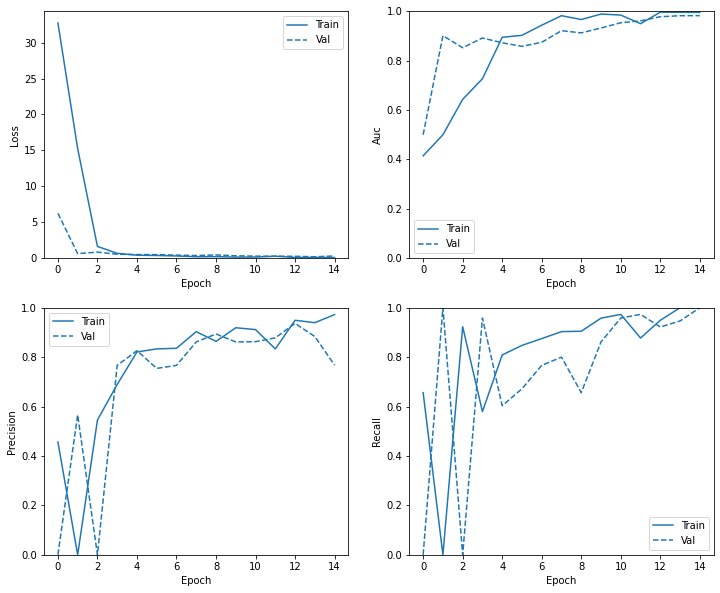

In [9]:
def plot_metrics(history):
  plt.rcParams['figure.figsize'] = (12, 10)
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

#Evaluate:

In [9]:
model.evaluate(test_generator)

23/23 [==============================] - 83s 4s/step - loss: 0.3561 - accuracy: 0.8639 - precision: 0.7991 - recall: 0.9722 - auc: 0.9536


[0.3560912609100342,
 0.8638888597488403,
 0.7990867495536804,
 0.9722222089767456,
 0.9536420106887817]

#Predictions:

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[1.]
INeedToTakeYourPulse.mp3 features a female speaker


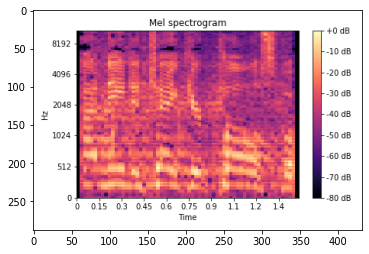

In [19]:
from keras.preprocessing import image

def prediction(input_file):
  AudioLocation = os.path.join(prediction_path, input_file)
  y, sr = librosa.load(AudioLocation)

  #Trim silent periods at start and end:
  y, index = librosa.effects.trim(y, top_db=45)

  #Compute mel spectrogram:
  MelSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000, n_fft = 512)
  
  #Save display of it:
  Spec_dB = librosa.power_to_db(MelSpec, ref=np.max)
  librosa.display.specshow(Spec_dB, x_axis='time', y_axis='mel', sr=sr)
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel spectrogram')
  plt.tight_layout()
  SpectrogramLocation = prediction_path + input_file[0:-4] + '.png'
  plt.savefig(SpectrogramLocation)
  plt.clf() #plt should be cleared after spectrogram is saved, for future uses.
  
  Spectrogram = image.load_img(SpectrogramLocation, target_size=(288, 432))
  x = image.img_to_array(Spectrogram)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  CNN = np.vstack([x])
  classes = model.predict(CNN, batch_size = 10)
  print(classes[0])
  if classes[0]<0.5:
    print(input_file + " features a male speaker")
  else:
    print(input_file + " features a female speaker")

prediction('INeedToTakeYourPulse.mp3')